# 使用データ調査 ＆ 前処理（前処理1）

### 0. このノートで行うこと

以下のカテゴリ付きデータを取得して、1記事ごとに、
- 最低限の前処理を行い、
- 形態素解析で単語に分かち書きをする。  

という前処理（前処理1）を行う。  
→ doc2vecのtraining dataとして用いるため、このデータを保存する。

---

### 1. 使用データ
カテゴリ付きのデータが欲しいので、以下のカテゴライズされたウェブ記事を使う。  
livedoor news corpus  
https://www.rondhuit.com/download.html#ldcc

以下のlivedoor newsの以下の9カテゴリ毎の記事が、1記事=１ファイルの  
形でまとめられている。

**9カテゴリ**
1. topic-news: トピック（トレンド）
2. sports-watch: スポーツ
3. it-life-hack: IT系
4. kaden-channel: 家電・PC
5. movie-enter: 映画
6. dokujo-tsushin: 女性（生活系）
7. smax: スマホ
8. livedoor-homme: 男性（生活系）
9. peachy: 女性（美容系）

----


### 2. 形態素解析による前処理
Mecabを使用
- ここではMecabは既知のものとする。
  - Web上にいくらでも良い記事があるので、適当に調べて使ってください。
  - たとえば、https://qiita.com/taroc/items/b9afd914432da08dafc8

## 1.使用データの調査

1.1 カテゴリ毎の記事数  
→　それぞれのカテゴリにある記事数は、約800記事。

1-2. カテゴリ毎、記事毎の文字数  
- 文字数はカテゴリによって若干の幅がある（800 ~ 1800).
- <300文字以下の記事も、数%ある。
- \>4000文字以上の記事も、数%ある。

#### 1-1. カテゴリ毎の記事数

In [1]:
import os

data_dir = './text/'
# 各directoryに、記事とは別にライセンスについて書いたファイルがあるので解析対象から除く。
skip_file = 'LICENSE.txt'

for i, (cur_dir, dirs, files) in enumerate(os.walk(data_dir)):
    if i > 0:
        files.remove(skip_file)
        print('%-20s n_files: %d' % (os.path.basename(cur_dir), len(files)))

movie-enter          n_files: 870
it-life-hack         n_files: 870
kaden-channel        n_files: 864
topic-news           n_files: 770
livedoor-homme       n_files: 511
peachy               n_files: 842
sports-watch         n_files: 900
dokujo-tsushin       n_files: 870
smax                 n_files: 870


#### 1-2. カテゴリ毎、記事毎の文字数

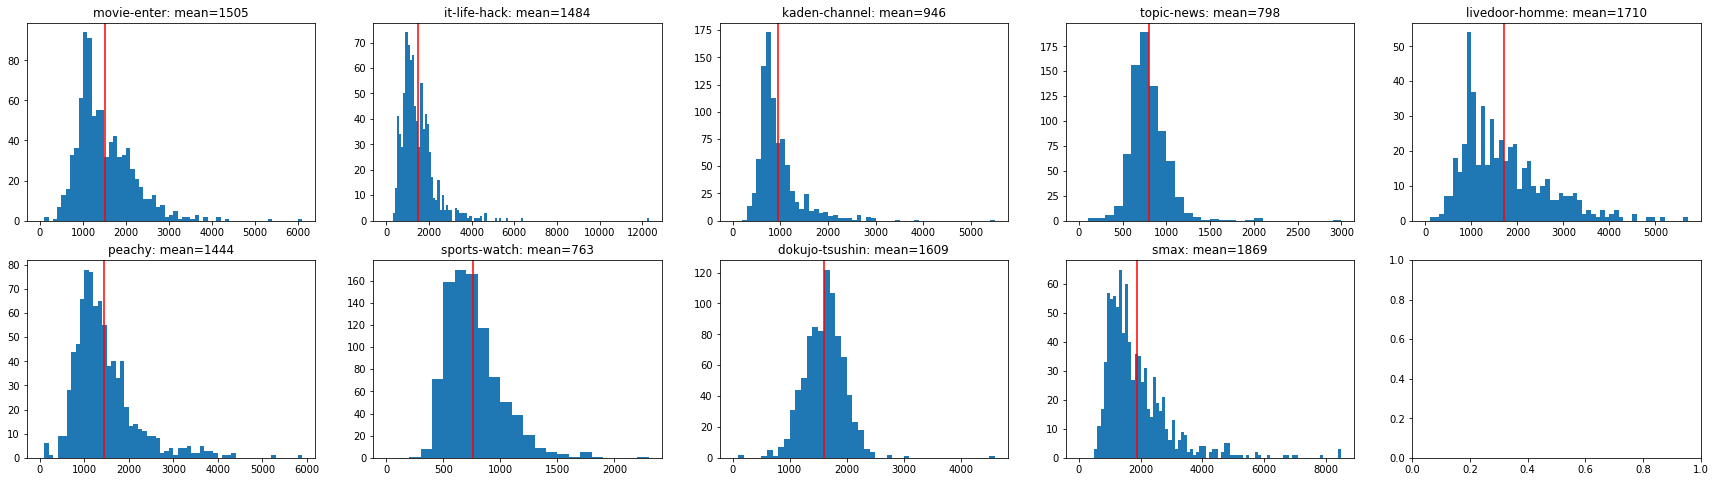

In [2]:
import matplotlib.pyplot as plt
import numpy as np

data_dir = './text/'
skip_file = 'LICENSE.txt'

fig, axes = plt.subplots(2, 5, figsize=(30, 8))

axes = axes.flatten()
for i, (cur_dir, dirs, files) in enumerate(os.walk(data_dir)):
    if i > 0:
        files.remove(skip_file)
        text_lens = []
        for fn in files:
            text = open(os.path.join(cur_dir, fn)).read()
            text_lens.append(len(text))
        mean_len = np.mean(text_lens)
        title = os.path.basename(cur_dir)
        
        ax = axes[i-1]
        bins = np.arange(0, np.max(text_lens)+100, 100)
        ax.hist(text_lens, bins=bins)
        ax.axvline(mean_len, color='r')
        ax.set_title('%s: mean=%d' % (title, mean_len))
#         break

#### 1-3. テキストの構造を目視で確認

ファイルの中身は以下のようになっているものが多い。
特に最初の二行は、すべての記事で
1. 記事URL
2. （おそらくクロールした）時間   

となっている。

「関連リンク」は常にあるわけではないが、それなりに存在するようだ。

**例： smax-6869011.txt  **  
"""  
http://news.livedoor.com/article/detail/6869011/  
2012-08-20T08:55:00+0900  
NTTドコモ、公式オンラインショップでも端末複数台購入で最大10,500円／台の割り引きが受けられる「家族セット割」を開始
NTTドコモは17日、公式オンラインショップ「ドコモオンラインショップ」において端末を複数台同時購入した場合に1台当たり最大10,500円を割り引く「WEB限定　家族でキャッシュバックキャンペーン」を2012年8月18日（土）から開始することをお知らせしています。キャンペーン期間は2012年9月30日（日）まで。  

...(略)...  

キャンペーンを適用する場合には、ドコモオンラインショップで購入時に対象条件を満たした場合に自動エントリーされるというこどで、条件さえ満たせば自動的に適用されます。試していないので不明ですが、きちんと対象になる場合には購入時に明記されるといいのですが、どうでしょうね……。

記事執筆：memn0ck

■関連リンク  
・エスマックス（S-MAX）  
・エスマックス（S-MAX） smaxjp on Twitter  
・「WEB限定　家族でキャッシュバックキャンペーン」を実施いたします！| お知らせ | ドコモオンラインショップ | NTTドコモ  
"""  

## 2. 形態素解析による前処理

#### 2-1. 前処理1: truncate 
- 1-3の結果より
    - 最初の２行は記事内容ではないので除く。
    - 「関連リンク」「関連記事」も除く。
       - 「関連リンク、記事」は、記事に近いテキストが書いてあるので、実際には意味があると思う。
       - ここでは純粋な"記事"内容にフォーカスするため除く。
    - 最後の記者の署名は、記事によってあったりなかったりで、フォーマットもバラバラなので、そのままにする。
- 1-2の結果より、記事の文字数には幅がある。
    - 文字数が少なすぎると、情報量が少なくてdoc2vecでうまくvector化できない。
        - ここでは300文字をthresholdとする（目視による恣意的な値。本来はちゃんと調査するべき）。
        - 300文字以下の記事は使用しない。
    - 文字数が多くても、doc2vecのvectorにbiasがかかる可能性は少ないと期待されるが、ここでは上限を2000文字にしてtruncateする。
        - (恣意的な値。本来はちゃんと調査するべき)

**例えば1-3の記事は、前処理１で以下のようになる。**


In [3]:
def _truncate(raw_text, min_char=None, max_char=None):
        def check_min_char(text, min_char):
            if len(text) < min_char:
                return None
            return text
        
        # "[2:]"にしてるのは、livedoor-newsの最初の2行（URL, 時間）を削除するため。
        truncate_texts = raw_text.split('\n')[2:]
        # 関連リンク、関連記事は後ろから探す。
        for i, line in enumerate(truncate_texts[::-1]):
            if line.find('関連リンク') >= 0 or line.find('関連記事') >= 0:
                truncate_texts = truncate_texts[:-(i+1)]
                break
        
        if max_char is None:
            text = ' '.join(truncate_texts)
            return check_min_char(text, min_char)
        
        text = ''
        for para in truncate_texts:
            if len(text) > max_char:
                break
            text += ' ' + para
        return check_min_char(text, min_char)
    
def preproc1(fn_text, min_char=None, max_char=None):
    raw_text = open(fn_text).read()
    text = _truncate(raw_text, min_char, max_char)
    return text

In [4]:
fn_text = './text/smax/smax-6869011.txt'  # 1-3の記事file
min_char = 300
max_char = 2000
preproc1(fn_text, min_char, max_char)

' NTTドコモ、公式オンラインショップでも端末複数台購入で最大10,500円／台の割り引きが受けられる「家族セット割」を開始 NTTドコモは17日、公式オンラインショップ「ドコモオンラインショップ」において端末を複数台同時購入した場合に1台当たり最大10,500円を割り引く「WEB限定\u3000家族でキャッシュバックキャンペーン」を2012年8月18日（土）から開始することをお知らせしています。キャンペーン期間は2012年9月30日（日）まで。  WEB限定\u3000家族でキャッシュバックキャンペーンは、現在、ドコモショップにおいて同一店舗でファミリー割引を提供している複数回線において複数台を同時購入する際に1台当たり最大10,500円を値引く「ドコモの家族セット割」を実施していますが、これのドコモオンラインショップ版となります。  キャンペーン内容は、同一ファミリー割引適用内の2回線以上で対象機種に機種変更をすると、1台当たり最大10,500円が毎月の請求額からキャッシュバックされます。請求額がキャッシュバック金額に満たない場合は、差額分をその翌月以降に繰り越してキャッシュバックされるということです。  対象機種はドコモのスマートフォンやiモードケータイで、タブレットやデータカード、ルーター、フォトパネル以外の全機種となっています。なお、ドコモオンラインショップ割対象機種については、対象外となるそうです。  その他の条件として、以下のいずれかの割引サービスまたは料金プランに加入する必要があります。  ■FOMAからFOMAへの機種変の場合 \u3000ファミ割MAX50 \u3000定額データ スタンダード割 \u3000定額データ スタンダード割２ \u3000定額データ １２８Ｋ割  ■FOMAからXiへの機種変更、またはXiからXiへの機種変更の場合 \u3000タイプXi にねん \u3000Xiデータプラン フラット にねん \u3000Xiデータプランにねん \u3000Xiデータプラン２ にねん  ※新規契約については、オンラインショップでお手続きと同時のファミリー割引申込ができないため対象外となります。ご了承ください。  キャンペーンを適用する場合には、ドコモオンラインショップで購入時に対象条件を満たした場合に自動エントリーされるというこどで

#### 2-2. 形態素解析
2-1の前処理１を行った後に、Mecabで形態素解析を行い、記事を単語ごとに分割する。  
**例えば、結果が以下。期待通りに動作していることを確認**

In [13]:
import MeCab
NEOLOGD_PATH = '/usr/local/lib/mecab/dic/mecab-ipadic-neologd'

def doc_to_words(fn_text, min_char, max_char):
    t = MeCab.Tagger('-d %s' % NEOLOGD_PATH)
    t.parse('')
    
    print(fn_text)
    doc = preproc1(fn_text, min_char, max_char)
    if doc is None:
        return None
    
    words = []
    m = t.parseToNode(doc)
    while m:
        word = m.surface
        if len(word) > 0:
            words.append(word)
        m = m.next
    return words

In [14]:
fn_text = './text/smax/smax-6869011.txt'  # 1-3の記事file
min_char = 300
max_char = 2000
print(doc_to_words(fn_text, min_char, max_char))

./text/smax/smax-6869011.txt
['NTTドコモ', '、', '公式', 'オンラインショップ', 'で', 'も', '端末', '複数', '台', '購入', 'で', '最大', '10', ',', '500円', '／', '台', 'の', '割り引き', 'が', '受け', 'られる', '「', '家族', 'セット', '割', '」', 'を', '開始', 'NTTドコモ', 'は', '17日', '、', '公式', 'オンラインショップ', '「', 'ドコモ', 'オンラインショップ', '」', 'において', '端末', 'を', '複数', '台', '同時', '購入', 'し', 'た', '場合', 'に', '1', '台', '当たり', '最大', '10', ',', '500円', 'を', '割り引く', '「', 'WEB', '限定', '\u3000', '家族', 'で', 'キャッシュバック', 'キャンペーン', '」', 'を', '2012年', '8月18日', '（', '土', '）', 'から', '開始', 'する', 'こと', 'を', 'お知らせ', 'し', 'て', 'い', 'ます', '。', 'キャンペーン期間', 'は', '2012年', '9月30日', '（', '日', '）', 'まで', '。', 'WEB', '限定', '\u3000', '家族', 'で', 'キャッシュバック', 'キャンペーン', 'は', '、', '現在', '、', 'ドコモショップ', 'において', '同', '一', '店舗', 'で', 'ファミリー', '割引', 'を', '提供', 'し', 'て', 'いる', '複数', '回線', 'において', '複数', '台', 'を', '同時', '購入', 'する', '際', 'に', '1', '台', '当たり', '最大', '10', ',', '500円', 'を', '値', '引く', '「', 'ドコモ', 'の', '家族', 'セット', '割', '」', 'を', '実施', 'し', 'て', 'い', 'ます', 'が', '、', 'これ', 'の

## 3. 上記1, 2を考慮して作った前処理の結果を確認
下記のとおり。期待通りの動作をしているのが確認できた。

In [1]:
!./preproc_docs.py --text_dir './text' --out_dir './preproc_data' --min_char 300 --max_char 2000 --each_num 2 --fn_words_list 'sample_words_list_mecab_pp1.pickle' --fn_category_map 'sample_category_map_pp1.pickle' --preproc_mode 'preproc1'

./text/movie-enter/movie-enter-5978741.txt
./text/movie-enter/movie-enter-6322901.txt
./text/it-life-hack/it-life-hack-6793390.txt
./text/it-life-hack/it-life-hack-6612842.txt
./text/kaden-channel/kaden-channel-6200042.txt
./text/kaden-channel/kaden-channel-6342265.txt
./text/topic-news/topic-news-6601493.txt
./text/topic-news/topic-news-6557651.txt
./text/livedoor-homme/livedoor-homme-5769340.txt
./text/livedoor-homme/livedoor-homme-5769426.txt
./text/peachy/peachy-4778626.txt
./text/peachy/peachy-5822542.txt
./text/sports-watch/sports-watch-6201891.txt
./text/sports-watch/sports-watch-5219218.txt
./text/dokujo-tsushin/dokujo-tsushin-6312503.txt
./text/dokujo-tsushin/dokujo-tsushin-5474199.txt
./text/smax/smax-6633904.txt
./text/smax/smax-6913983.txt


In [2]:
import pickle
with open( './preproc_data/sample_words_list_mecab_pp1.pickle', 'rb') as f1:
    words_list = pickle.load(f1)
with open('./preproc_data/sample_category_map_pp1.pickle', 'rb') as f2:
    category_map = pickle.load(f2)
category_map, words_list

({'t0': 'movie-enter',
  't1': 'movie-enter',
  't2': 'it-life-hack',
  't3': 'it-life-hack',
  't4': 'kaden-channel',
  't5': 'kaden-channel',
  't6': 'topic-news',
  't7': 'topic-news',
  't8': 'livedoor-homme',
  't9': 'livedoor-homme',
  't10': 'peachy',
  't11': 'peachy',
  't12': 'sports-watch',
  't13': 'sports-watch',
  't14': 'dokujo-tsushin',
  't15': 'dokujo-tsushin',
  't16': 'smax',
  't17': 'smax'},
 [TaggedDocument(words=['【', 'DVD', 'エンター', '！', '】', '誘拐犯', 'に', '育て', 'られ', 'た', '女', 'が', '目', 'に', 'し', 'た', '真実', 'は', '、', '孤独', 'か', '幸福', 'か', '\u3000', '2005年', '11月', 'から', '翌', '2006年', '7月', 'まで', '読売新聞', 'にて', '連載', 'さ', 'れ', 'た', '、', '直木賞', '作家', '・', '角田光代', 'による', '初', 'の', '長編', 'サスペンス', '『', '八日目の蝉', '』', '。', '2010年', 'に', '檀れい', 'と', '北乃きい', 'の', '出演', 'により', 'テレビドラマ', '化', 'さ', 'れ', 'た', '同', '作が', '、', '2011年', '4月', 'に', '永作博美', 'と', '井上真央', 'の', '出演', 'によって', '映画化', '。', 'そして', '、', '劇場公開', 'から', '半年', 'が', '過ぎ', 'た', '10月28日', '、', 'DVD', '＆', 'ブルーレイ'